## La spiegazione di questo codice forse la metto forse no, sicuro fa riferimento a record_linkage

In [1]:
import recordlinkage
from recordlinkage import Compare
from recordlinkage.preprocessing import clean
import pandas as pd

companies_df = pd.read_csv('../aziende_normalizzate.csv')

### Stai attento peró che con l'approccio sotto riportato 2 righe matchano solo se entrambi i valori fanno match

In [2]:
indexer = recordlinkage.Index()
indexer.block(left_on=['foundation_year', 'country'])  #proviamo solo su normalizzazione

candidate_pairs = indexer.index(companies_df)

print(f'Numero di coppie candidate: {len(candidate_pairs)}')

Numero di coppie candidate: 498622


In [5]:
candidate_pairs_index = pd.MultiIndex.from_tuples(candidate_pairs, names=['left', 'right'])

companies_df = companies_df.reset_index(drop=True)

companies_df = companies_df.fillna("")

compare = Compare()
compare.string('city', 'city', method='jarowinkler', threshold=0.85, label='city')
compare.string('company_name', 'company_name', method='jarowinkler', threshold=0.85, label='company_name')

try:
    features = compare.compute(candidate_pairs_index, companies_df)
    display(features.head(10))
except Exception as e:
    print("Errore durante il calcolo delle feature sull'intero dataset:", e)

city  company_name
left right                    
6364 0       0.0           0.0
6376 0       0.0           0.0
     6364    0.0           0.0
6643 0       0.0           0.0
     6364    0.0           0.0
     6376    0.0           0.0
6847 0       0.0           0.0
     6364    0.0           0.0
     6376    0.0           0.0
     6643    0.0           0.0

In [6]:
matches = features[features.sum(axis=1) > 0.9]

print(f'Numero di corrispondenze trovate: {len(matches)}')

matches.head()

Numero di corrispondenze trovate: 32659


,,city,company_name
left,right,,
9921,9920,0.0,1.0
10474,10473,0.0,1.0
10557,10556,0.0,1.0
33292,33291,0.0,1.0
41310,41309,0.0,1.0


In [7]:
grouped_matches = matches.loc[matches.sum(axis=1).groupby(level=0).idxmax()]

grouped_matches.head(100)

,,city,company_name
left,right,,
68,67,0.0,1.0
73,72,0.0,1.0
106,105,0.0,1.0
156,155,0.0,1.0
171,170,0.0,1.0
...,...,...,...
3047,3046,1.0,0.0
3058,121,1.0,0.0
3139,3135,1.0,1.0


In [8]:
import networkx as nx

def merge_values(series):
    unique_values = set(series.dropna()) 
    return ' | '.join(map(str, unique_values)) if len(unique_values) > 0 else ''  
G = nx.Graph()
G.add_edges_from(grouped_matches.index.tolist())

connected_components = list(nx.connected_components(G))

duplicate_groups = {node: i for i, component in enumerate(connected_components) for node in component}

companies_df['group_id'] = companies_df.index.map(duplicate_groups)

def print_aggregated_rows(group_id, group_data):
    if len(group_data) >= 3:  
        print(f"\nAggregazione del gruppo {group_id} (con {len(group_data)} elementi):")
        group_data = group_data.reset_index()  
        print(group_data[['company_name', 'city', 'country', 'address']])  

final_df = companies_df.groupby('group_id').agg(merge_values).reset_index()

final_df = final_df.drop(columns=['group_id'])

for group_id, group_data in companies_df.groupby('group_id'):
    print_aggregated_rows(group_id, group_data)

final_df.to_csv("deduplicated_companies2.csv", index=False)

display(final_df.head())


Aggregazione del gruppo 6.0 (con 3 elementi):
  company_name city country address
0      7layers        italy        
1      7layers        italy        
2      7layers        italy        

Aggregazione del gruppo 7.0 (con 3 elementi):
  company_name city country address
0      84codes       sweden        
1      84codes       sweden        
2  84codes.com       sweden        

Aggregazione del gruppo 8.0 (con 9 elementi):
             company_name   city country address
0          3pillar global  noida   india        
1              94.3 my fm  noida   india        
2  algoworks technologies  noida   india        
3            awc software  noida   india        
4              bharat bpo  noida   india        
5    clarks inn of hotels  noida   india        
6             magicbricks  noida   india        
7         sharda hospital  noida   india        
8       velocity software  noida   india        

Aggregazione del gruppo 10.0 (con 3 elementi):
               company_name city 

,company_id,company_name,trade_name,industry,sector,categories,company_status,company_type,address,postal_code,...,emtak_code,nace_code,facebook,twitter,pinterest,instagram,investors,region,notes_or_description,modified
0,,2c2p,,fintech,fintech,,,,,,...,,,,,,,,,,False
1,,2e vertriebs | 2e vertriebs-gmbh,,retail,retail,,,,,,...,,,,,,,,,,False
2,,3c,,automobiles,automobiles,,,,,,...,,,,,,,,,,False
3,,3zehn auto discount,,automobiles,automobiles,,,,,,...,,,,,,,,,,False
4,,4most,,insurance,insurance,,,,,,...,,,,,,,,,,False


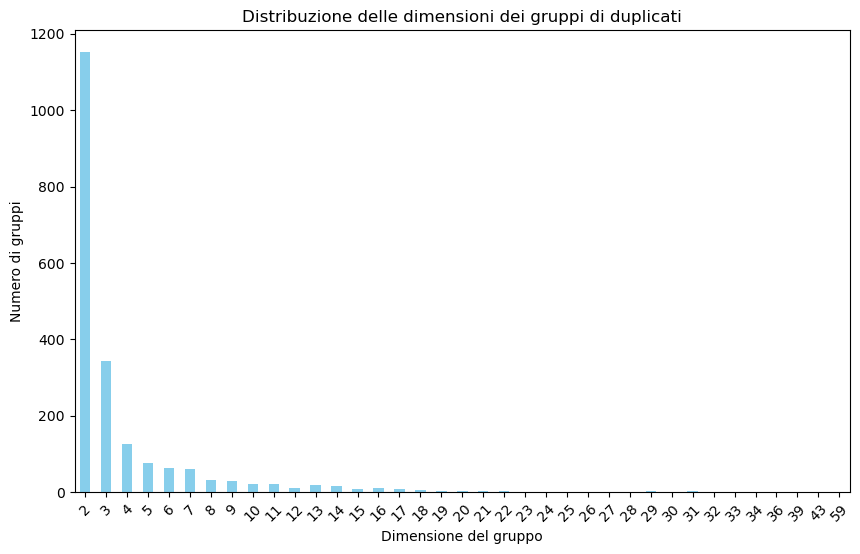

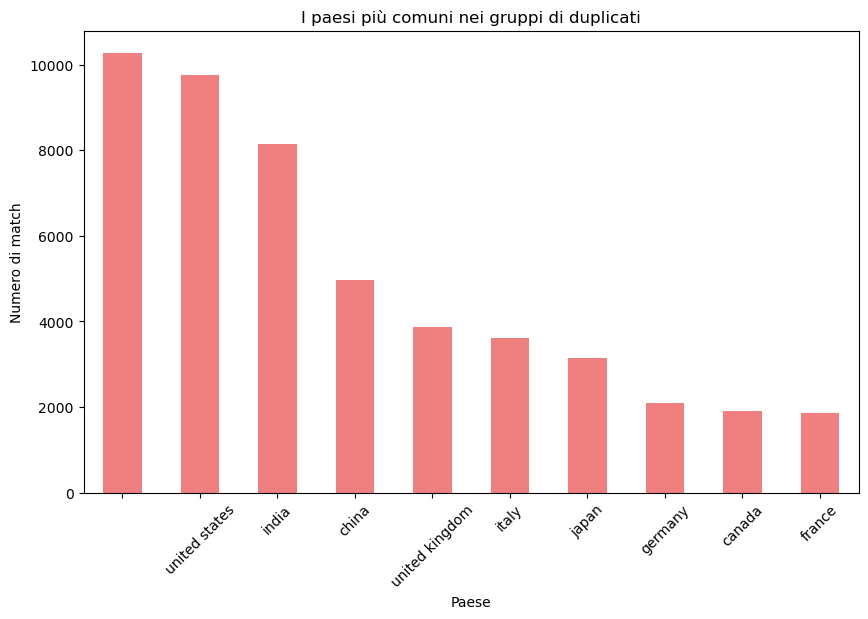

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


group_sizes = companies_df.groupby('group_id').size()

group_sizes_filtered = group_sizes[group_sizes > 1]

plt.figure(figsize=(10, 6))
group_sizes_filtered.value_counts().sort_index().plot(kind='bar', color='skyblue')

plt.title('Distribuzione delle dimensioni dei gruppi di duplicati')
plt.xlabel('Dimensione del gruppo')
plt.ylabel('Numero di gruppi')
plt.xticks(rotation=45)
plt.show()


country_counts = companies_df['country'].value_counts()
plt.figure(figsize=(10, 6))
country_counts.head(10).plot(kind='bar', color='lightcoral')
plt.title('I paesi più comuni nei gruppi di duplicati')
plt.xlabel('Paese')
plt.ylabel('Numero di match')
plt.xticks(rotation=45)
plt.show()